In [1]:
import os
import sys
sys.path.append(os.path.abspath('../..'))
from data import SyntheticPV
from models import ApproximatePVLFM, ApproximateGP
from pv_plot import plot_lfm
from data.utils import print_lfm_param_table

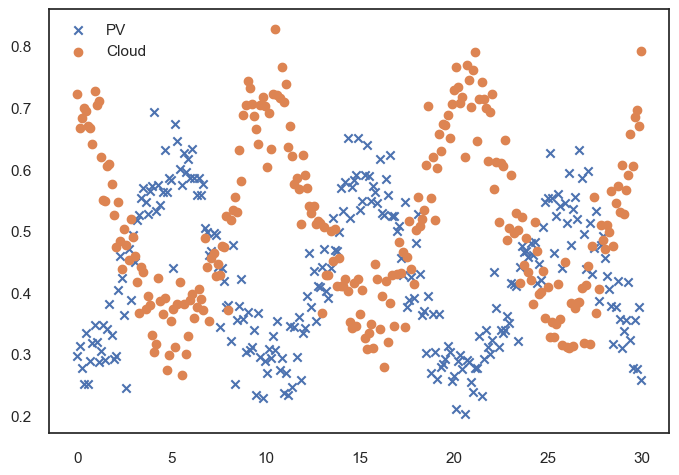

In [137]:
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'Arial'
# dataset = SyntheticPV(num_discrete=8)
plt.scatter(dataset.times, dataset.pv, label='PV', marker='x')
plt.scatter(dataset.times, dataset.cloud, label='Cloud', marker='o')
plt.legend();

In [119]:
from gpytorch.means import ZeroMean
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel
from gpytorch.likelihoods import GaussianLikelihood
from alfi.configuration import VariationalConfiguration


num_outputs = 1
gp_config = {
    'type' : 'stochastic',
    'name' : 'cholesky',
    'jitter' : 1e-6,
}
gp_model = ApproximateGP(dataset=dataset,
                         mean=ZeroMean(),
                         covar=ScaleKernel(RBFKernel()),
                         likelihood=GaussianLikelihood(),
                         config=gp_config)

lfm = ApproximatePVLFM(dataset=dataset,
                       num_outputs=num_outputs,
                       gp_model=gp_model,
                       config=VariationalConfiguration(num_samples=70))

In [120]:
lfm.fit(n_iter=150, lr=0.2)

Iter 10/150, Loss: 0.35081844876543683
Iter 20/150, Loss: -0.7391434320108317
Iter 30/150, Loss: -1.0559293762489335
Iter 40/150, Loss: -1.170249890780058
Iter 50/150, Loss: -1.2088272722772417
Iter 60/150, Loss: -1.2213414210820042
Iter 70/150, Loss: -1.2255427511656434
Iter 80/150, Loss: -1.22078651123894
Iter 90/150, Loss: -1.2233446042377814
Iter 100/150, Loss: -1.2336659787001185
Iter 110/150, Loss: -1.2414805078592723
Iter 120/150, Loss: -1.2333175656605782
Iter 130/150, Loss: -1.2429848840350661
Iter 140/150, Loss: -1.2374379831995688
Iter 150/150, Loss: -1.2412828245442615


In [133]:
import numpy as np
def plot_lfm(lfm, dataset):
    """
    Plot the latent force and the PV predictions

    Args:
        lfm (models.LFM): LFM model
        dataset (datasets.PVData): dataset
    """

    pred_cloud = lfm(dataset.times)
    cloud_mean = pred_cloud.mean.detach().squeeze(0).numpy()
    cloud_var = pred_cloud.variance.detach().squeeze(0).numpy()
    cloud_std = np.sqrt(cloud_var)

    pv_init = dataset.pv_init
    pv_var = cloud_var[0] # assume casual relationship between cloud and PV
    pv_dist = lfm.predict_pv(pv_init, pv_var, dataset.times)

    pv_mean = pv_dist.mean.detach().squeeze(0).numpy()
    pv_var = pv_dist.variance.detach().squeeze(0).numpy()
    pv_std = np.sqrt(pv_var)

    cloud_init_test = cloud_mean[-1]
    cloud_var_test = cloud_var[-1] 
    cloud_dist_test = lfm.predict_cloud(cloud_init_test, cloud_var_test, dataset.times_test)

    cloud_mean_test = cloud_dist_test.mean.detach().squeeze(0).numpy()
    cloud_var_test = cloud_dist_test.variance.detach().squeeze(0).numpy()
    cloud_std_test = np.sqrt(cloud_var_test)

    pv_init_test = pv_mean[-1]
    pv_var_test = cloud_var_test[0]
    pv_dist_test = lfm.predict_pv(pv_init_test, pv_var_test, dataset.times_test)

    pv_mean_test = pv_dist_test.mean.detach().squeeze(0).numpy()
    pv_var_test = pv_dist_test.variance.detach().squeeze(0).numpy()
    pv_std_test = np.sqrt(pv_var_test)

    plt.rcParams['font.family'] = 'Arial'

    fig, ax = plt.subplots(1, 1, figsize=(20, 9))

    ax.scatter(dataset.times, dataset.cloud, marker='o', alpha=0.5, color='k', label='Cloud Data')
    ax.scatter(dataset.times, dataset.pv, marker='x', alpha=0.5, color='k', label='PV Data')
    ax.scatter(dataset.times_test, dataset.cloud_test, marker='o', alpha=0.5, color='k')
    ax.scatter(dataset.times_test, dataset.pv_test, marker='x', alpha=0.5, color='k')

    ax.plot(dataset.times, cloud_mean, label='Latent Force', color='b')
    ax.fill_between(dataset.times, cloud_mean - 1.96 * cloud_std, cloud_mean + 1.96 * cloud_std, alpha=0.1, color='b')

    ax.plot(dataset.times, pv_mean, label='Predicted', color='r')
    ax.fill_between(dataset.times, pv_mean - 1.96 * pv_std, pv_mean + 1.96 * pv_std, alpha=0.1, color='r')

    ax.plot(dataset.times_test, cloud_mean_test, color='b')
    ax.fill_between(dataset.times_test, cloud_mean_test - 1.96 * cloud_std_test, cloud_mean_test + 1.96 * cloud_std_test, alpha=0.1, color='b')

    ax.plot(dataset.times_test, pv_mean_test, color='r')
    ax.fill_between(dataset.times_test, pv_mean_test - 1.96 * pv_std_test, pv_mean_test + 1.96 * pv_std_test, alpha=0.1, color='r')

    y_min = min(min(cloud_mean - 1.96 * cloud_std), min(pv_mean - 1.96 * pv_std), 
                min(cloud_mean_test - 1.96 * cloud_std_test), min(pv_mean_test - 1.96 * pv_std_test))
    y_max = max(max(cloud_mean + 1.96 * cloud_std), max(pv_mean + 1.96 * pv_std),
                max(cloud_mean_test + 1.96 * cloud_std_test), max(pv_mean_test + 1.96 * pv_std_test))

    ylim = (y_min - 0.05, y_max + 0.05)
    
    ax.axvspan(dataset.times[0], dataset.times[-1], alpha=0.2, color='gray')

    ax.scatter(dataset.times[-1], cloud_init_test, marker='o', color='b',  s=200, label='Initial Cloud Cover')
    ax.scatter(dataset.times[-1], pv_init_test, marker='o', color='r',  s=200, label='Initial PV')
    arrow = ax.arrow(dataset.times[-1], y_max + 0.05, 10, 0, head_width=0.02, head_length=0.5, fc='k', ec='k')

    ax.annotate('Extrapolation', xy=(dataset.times[-1] + 5, y_max + 0.06), fontsize=20, ha='center')
    ax.set_xlabel('Time Steps', fontsize=20)
    ax.set_ylabel('PV / Cloud Cover', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylim(y_min -0.05, y_max + 0.1)
    
    # # create a new subplot for the legend
    fig = plt.gcf()
    ax = plt.subplot(111)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(0, 1 + 0.05), fontsize=20, fancybox=True, shadow=True,
                ncol=6, frameon=True)
   

    plt.tight_layout()
    plt.show()


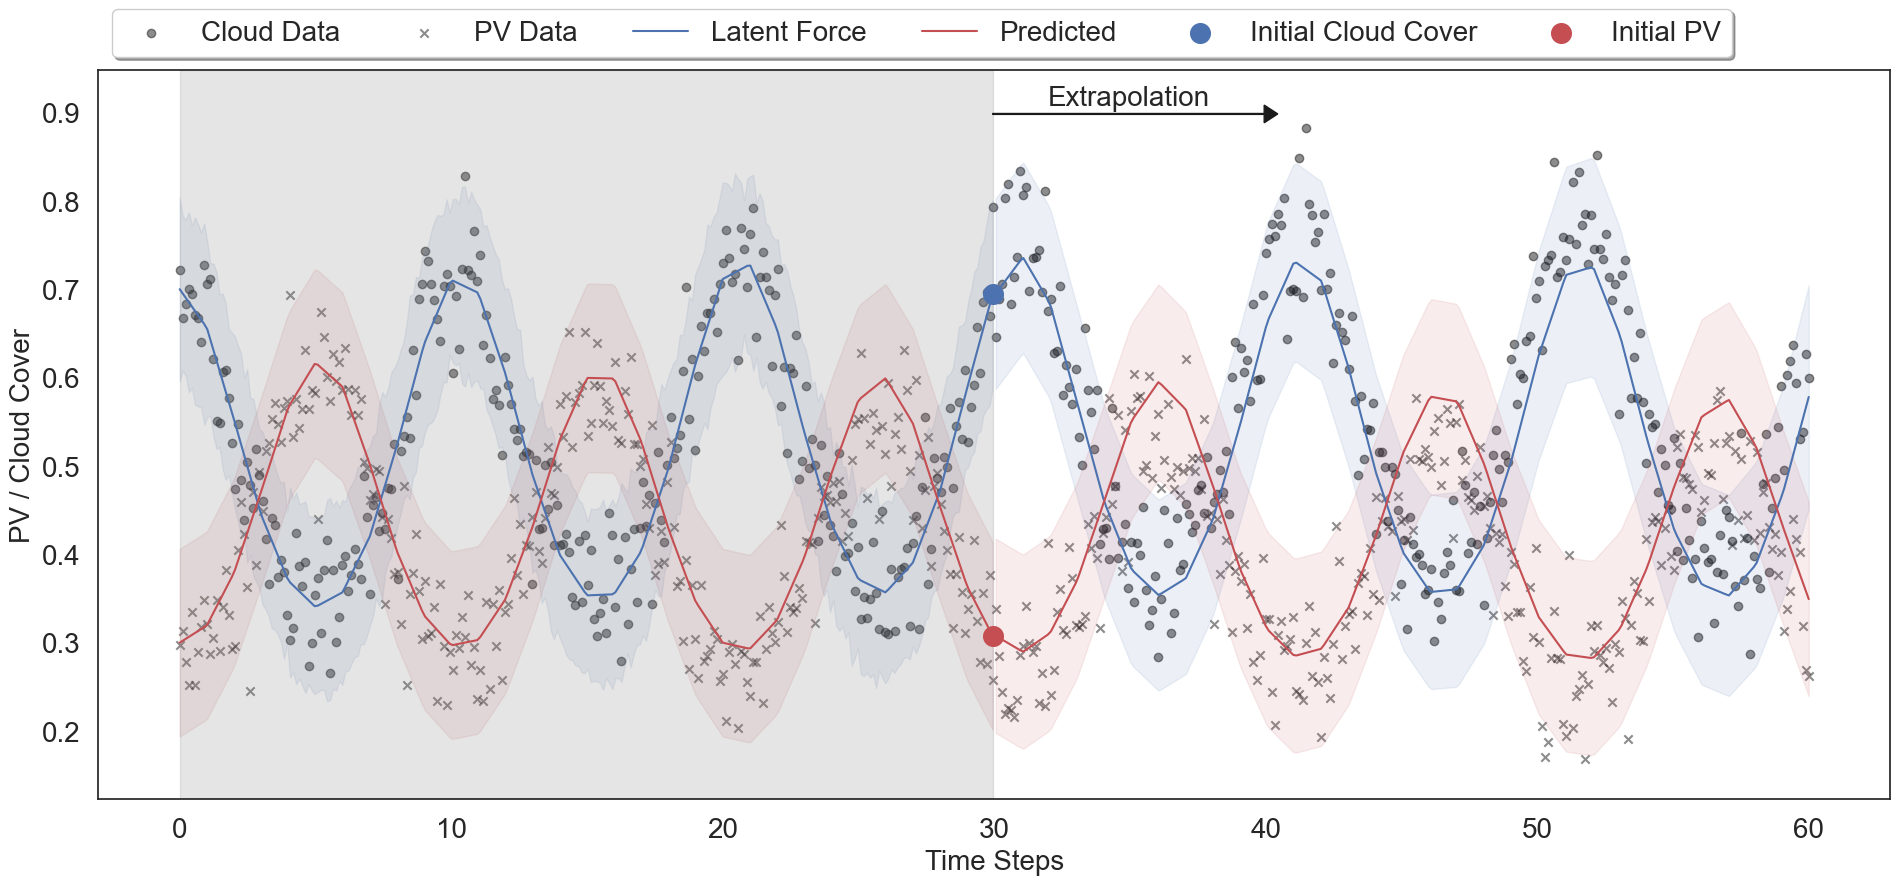

In [134]:
plot_lfm(lfm, dataset)

In [29]:
print_lfm_param_table(lfm, dataset)

--------------------------------------------------
| Parameter  	 | True 	 |  Learned 	 |
--------------------------------------------------
|  a 		 |  0.010 	 | 0.004 	 |
--------------------------------------------------
|  b 		 |  0.384 	 | 0.404 	 |
--------------------------------------------------
|  c 		 |  0.177 	 | 0.176 	 |
--------------------------------------------------
